# Project Description

### TODO
#### We are using a CNN, max pooling, and n-grams (a sequence of n words in a sentence) to construct this project

## Imporant Documentation

### PyTorch Resources:
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
#####    - https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058#:~:text=An%20N%2Dgram%20means%20a,3%2Dgram%20(trigram).

### Step 1: Tokenize data and build vocab

In [2]:
import re
import nltk
import torch
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
class Preprocessing:
    def __init__(self, vocab_size, seq_len):
        self.file_name = 'clickbait_data.csv'
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.vocab = None
        self.x_tokenized = None
        self.x_padded = None
        self.x = None
        self.y = None

        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

    def load_dataset(self):
        # Load dataset from local directory 
        df = pd.read_csv(self.file_name)
        df = shuffle(df)
        self.x = df['headline'].values
        self.y = df['clickbait'].values

    def clean_data(self):
        # Clean data by removing all special characters. Convert words to lowercase
        self.x = [re.sub(r'\'','', headline).lower() for headline in self.x]
        self.x = [re.sub(r'[^A-Za-z0-9]+',' ', headline).lower() for headline in self.x]

    def tokenization(self):
        # Tokenize all headlines
        self.x = [nltk.tokenize.wordpunct_tokenize(headline) for headline in self.x]

    def build_vocab(self):
        # Build vocab and return 'vocab_size' most common words
        self.vocab = dict()

        fdist = nltk.FreqDist()
        for headline in self.x:
            for word in headline:
                fdist[word] += 1
        
        common_words = fdist.most_common(self.vocab_size)

        for count, word in enumerate(common_words):
            self.vocab[word[0]] = count+1
    
    def word_to_idx(self):	
        # Convert each token into index based representation 
        self.x_tokenized = list()
        
        for sentence in self.x:
            temp = list()
            for word in sentence:
                if word in self.vocab.keys():
                    temp.append(self.vocab[word])
            self.x_tokenized.append(temp)
    
    def padding_sentences(self):
        # Make all sentences equal length. 
        # If sentence is smaller than minimum length, pad it 
        idx = 0
        self.x_padded = list()

        for sentence in self.x_tokenized:
            while len(sentence) < self.seq_len:
                sentence.insert(len(sentence), idx)
            self.x_padded.append(sentence)
            
        self.x_padded = np.array(self.x_padded)

    def split_data(self):
        # Split data into training and testing sets
        trnSize = int(len(self.x_padded) * .8)
        tstSize = int(len(self.x_padded) * .2)
        self.x_train = self.x_padded[:trnSize]
        self.y_train = self.y[:trnSize]
        self.x_test = self.x_padded[trnSize:]
        self.y_test = self.y[trnSize:]


### Step 2: Build the Model

In [4]:
class HeadlineClassifier(torch.nn.ModuleList):
    def __init__(self, seq_len, num_words, embedding_size, dropout, out_size, stride, filters):
        super(HeadlineClassifier, self).__init__()

        self.seq_len = seq_len
        self.num_words = num_words
        self.embedding_size = embedding_size

        # Dropout (used to reduce chance of overfitting by "dropping" units in neural net). Probability (p) set to 0.25
        self.dropout = torch.nn.Dropout(dropout)

        # Kernel sizes for CNN
        #pass it as params when we change the implmentation. Can keep it like this for now
        self.filters = filters

        # Output size for convolutions
        self.out_size = out_size
        # Number of strides for convolutions
        self.stride = stride

        # Embedding layer (lookup table that stores embeddings of a fixed dictionary and size)
        self.embedding = torch.nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0)

        # Convolution layers (each is a 1D convolution over an input)
        self.clayers = [torch.nn.Conv1d(self.seq_len, self.out_size, fltr, self.stride) for fltr in self.filters]
        
            
        # Max pooling layers (each applies 1D max pooling to input) 
        self.poollayers = [torch.nn.MaxPool1d(fltr, self.stride) for fltr in self.filters]

        # Fully connected layer (applies linear transformation to data)
        self.fc = torch.nn.Linear(self.size_of_input(), 1)

    
    def size_of_input(self):
        # Calculate input size for linear layer 
        pout = 0
        for filter in self.filters:
            cout = math.floor(((self.embedding_size - (filter - 1) - 1)/self.stride) + 1)
            pout += math.floor(((cout - (filter - 1) - 1) / self.stride) + 1)
        
        return pout * self.out_size

    '''Create forward pass of neural network. Consists of mainly ordering the different types of layers
        Steps:
            1. Pass tokenized words through embedding layer
            2. Pass each embedded sentence through each convolution and max pooling layer
            3. Reduce vector to linear layer
    '''
    def forward_pass(self, input_X):
        
        x = self.embedding(input_X)

        layerPasses = list()
        for i in range(len(self.filters)):
            temp = self.clayers[i](x)
            #TODO: Why not sigmoid (there are a few common functions we can try)? Maybe this can be a question we answer
            temp = torch.relu(temp)
            temp = self.poollayers[i](temp)
            layerPasses.append(temp)

        unn = torch.cat(layerPasses, 2)
        unn = unn.reshape(unn.size(0), -1)

        output = torch.sigmoid(self.dropout(self.fc(unn))).squeeze()
        return output


In [5]:
class DataClass(torch.utils.data.Dataset):
   def __init__(self, x, y):
      self.x = x
      self.y = y
      
   def __len__(self):
      return len(self.x)
      
   def __getitem__(self, idx):
      return self.x[idx], self.y[idx]

In [14]:
# Train model
# Returns: Training Loss, Testing Loss, Training Accuracy, Testing Accuracy
def train(model, dataset, learning_rate, batch_size, train_data, test_data, numOfIter):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size)

    opt = torch.optim.SGD(model.parameters(), lr = learning_rate)

    trainLoss, testLoss, trainAccuracy, testAccuracy = [], [], [], []
    for iter in range(numOfIter):
        model.train()
        train_predictions = []

        for x,y in train_loader:
            y = y.type(torch.FloatTensor) # Convert type of labels
            
            pred = model.forward_pass(x) # Forward pass on input data 

            loss = torch.nn.functional.binary_cross_entropy(pred, y) # Measure the Binary Cross Entropy between the target and input probabilities

            opt.zero_grad() # Set gradients to zero 

            loss.backward()

            opt.step()

            train_predictions += list(pred.detach().numpy()) # Append training predictions 

        # Evaluate model
        model.eval() # Put model in evaluation mode
        test_predictions = []
        with torch.no_grad(): # Disable gradient calculation 
            for x, y in test_loader:
                pred = model.forward_pass(x)
                test_predictions += list(pred.detach().numpy()) # Append test predictions

        # Get model accuracy 
        train_acc = calc_acc(dataset.y_train, train_predictions)
        test_acc = calc_acc(dataset.y_test, test_predictions)
        train_loss = loss.item()
        test_loss = loss.item()
        
        # Gather training and testing loss & accuracy
        trainLoss.append(train_loss)
        testLoss.append(test_loss)
        trainAccuracy.append(train_acc)
        testAccuracy.append(test_acc)
        
        # Print training and testing accuracy for each iteration
        print("Iteration: %d, Loss: %.5f, Train Accuracy: %.5f" % (iter+1, train_loss, train_acc))
        print("Iteration: %d, Loss: %.5f, Test Accuracy: %.5f" % (iter+1, test_loss, test_acc))
    
    return (trainLoss, testLoss, trainAccuracy, testAccuracy)
        

In [12]:
# Get accuracy of model 
def calc_acc(actual, predictions):
    clickbait = 0
    not_clickbait = 0

    for true, pred in zip(actual, predictions):
        if (pred >= .5) and (true == 1): # True positive (prediction is 'clickbait' and actual is 'clickbait')
            clickbait += 1
        elif (pred < .5) and (true == 0): # True negative (prediction is 'not clickbait' and actual is 'not clickbait')
            not_clickbait += 1

    # Return accuracy of model
    return (clickbait + not_clickbait) / len(actual)


In [15]:
# Initialize instance of Preprocessing class
dataset = Preprocessing(2000, 30)

# Load dataset
dataset.load_dataset()

# Clean and tokenize dataset
dataset.clean_data()
dataset.tokenization()

# Build vocab 
dataset.build_vocab()

# Index words and pad headline sentences
dataset.word_to_idx()
dataset.padding_sentences()

# Split data into training and testing sets
dataset.split_data()

# Print data specifics:
print("Dataset size: ", len(dataset.x))
#print("Dataset vocab: ", dataset.vocab)
print("Dataset training size: ", len(dataset.y_train))
print("Dataset testing size: ", len(dataset.x_test))

# Initialize model (TODO: optimize parameters)
seq_len = 30
vocab_size = len(dataset.vocab)
embedding_size = 64
dropout = 0.25
out_size = 32
stride = 2
filters = [2,3,4,5]
model = HeadlineClassifier(seq_len, vocab_size, embedding_size, dropout, out_size, stride, filters)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print("--------------Found CUDA device, prepare for S P E E D.--------------")
else:
    print("--------------Training on CPU--------------")
model = model.to(device)

# Creating testing and training datasets
train_set = DataClass(dataset.x_train, dataset.y_train)
test_set = DataClass(dataset.x_test, dataset.y_test)

# Train model
learning_rate = 0.01
batch_size = 12
numOfIter = 10
trainLoss, testLoss, trainAccuracy, testAccuracy = train(model, dataset, learning_rate, batch_size, train_set, test_set, numOfIter)


Dataset size:  32000
Dataset training size:  25600
Dataset testing size:  6400
--------------Training on CPU--------------
Iteration: 1, Loss: 0.19509, Train Accuracy: 0.69316
Iteration: 1, Loss: 0.19509, Test Accuracy: 0.78516
Iteration: 2, Loss: 0.19484, Train Accuracy: 0.73359
Iteration: 2, Loss: 0.19484, Test Accuracy: 0.81984
Iteration: 3, Loss: 0.26710, Train Accuracy: 0.74461
Iteration: 3, Loss: 0.26710, Test Accuracy: 0.81906
Iteration: 4, Loss: 0.11076, Train Accuracy: 0.75703
Iteration: 4, Loss: 0.11076, Test Accuracy: 0.81750
Iteration: 5, Loss: 0.26618, Train Accuracy: 0.75949
Iteration: 5, Loss: 0.26618, Test Accuracy: 0.83359


KeyboardInterrupt: 

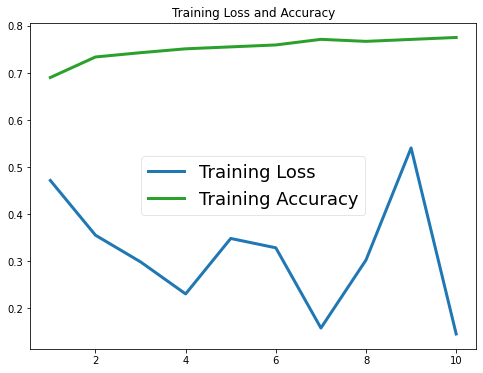

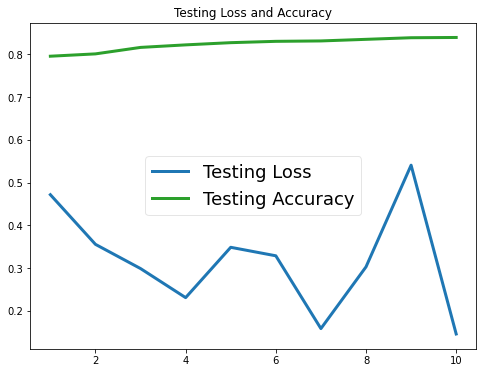

In [10]:
#plot losses/accuracies
x = list(range(1, numOfIter + 1))
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(x, trainLoss, label='Training Loss', color='tab:blue', linewidth=3)
plt.plot(x, trainAccuracy, label='Training Accuracy', color='tab:green', linewidth=3)
plt.title('Training Loss and Accuracy')
plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(x, testLoss, label='Testing Loss', color='tab:blue', linewidth=3)
plt.plot(x, testAccuracy, label='Testing Accuracy', color='tab:green', linewidth=3)
plt.title('Testing Loss and Accuracy')
plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
plt.show()